In [1]:
import h5py
import numpy as np
import matplotlib.pyplot as plt

from pygama.analysis.peak_fitting import gauss_mode_max, gauss_mode_width_max, gauss_basic
from pygama import DataGroup, lh5
from pygama.analysis.histograms import plot_hist
from pygama.utils import plot_func

dsp_dir = '/global/cfs/cdirs/legend/data/cage/LH5/dsp'

# Timestamp Correction

In [2]:
#def dsp_to_hit_cage(f_dsp, f_hit, dg, n_max=None, verbose=False, t_start=None):
    
def correct_timestamps(f_dsp):
    dsp = h5py.File(f_dsp)
    ts_old = np.array(dsp['ORSIS3302DecoderForEnergy']['dsp']['timestamp'])
    ts_old = ts_old.astype(np.int64)
    ts_sec = []
    clock = 100e6 # 100 MHz
    UINT_MAX = 4294967295 # (0xffffffff)
    t_max = UINT_MAX / clock
    ts = ts_old/ clock
    tdiff = np.diff(ts)
    tdiff = np.insert(tdiff, 0 , 0)
    iwrap = np.where(tdiff < 0)
    iloop = np.append(iwrap[0], len(ts))
    ts_new, t_roll = [], 0
    for i, idx in enumerate(iloop):
        ilo = 0 if i==0 else iwrap[0][i-1]
        ihi = idx
        ts_block = ts[ilo:ihi]
        ts_block = (np.array(ts_block)).astype(np.uint64)
        ts_new.append(ts_block + t_roll)
        t_last = ts[ilo-1]
        t_diff = t_max - t_last
        t_roll += t_last + t_diff
    ts_sec = np.concatenate(ts_new)
    return ts_sec

# Gain Jumps

In [18]:
time_intervals = 60

def find_1460(timestamps, trapEftp):
    ehist, t_edges, e_edges = np.histogram2d(timestamps,  trapEftp, bins=[np.arange(0, timestamps[-1], np.minimum(time_intervals, int(timestamps[-1]-1))), np.arange(1000,5000, 10)])
    ind = np.unravel_index(np.argmax(ehist), ehist.shape)
    return e_edges[ind[1]]

def hist_jump_in_run(run, cycles, dsp_folder, plot=True):
    ehists = []
    blhists = []
#    esig = 0
#    blsig = 0
    r = run
    for c in cycles:
        f_dsp = f"{dsp_folder}/cage_run{r}_cyc{c}_dsp.lh5"
        try:
            dsp = h5py.File(f_dsp)
        except OSError:
            continue
        trapEftp = np.array(dsp['ORSIS3302DecoderForEnergy']['dsp']['trapEftp'])
        baseline = np.array(dsp['ORSIS3302DecoderForEnergy']['dsp']['bl'])
        ts = np.array(dsp['ORSIS3302DecoderForEnergy']['dsp']['timestamp'])
        ts_corrected = correct_timestamps(f_dsp)
        bl = np.mean(baseline)
        adu1460 = find_1460(ts_corrected, trapEftp)
        if plot:
            fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(24,10))
            fig.suptitle(f'run{r} cycle{c}')

            eh = ax1.hist2d(ts_corrected, trapEftp, bins=[np.arange(0, ts_corrected[-1],np.minimum(time_intervals, int(ts_corrected[-1]-1))),np.arange(adu1460-100, adu1460+101)])[:-1]
            ye = [eh[2][np.argmax(eh[0][j][:])] for j in range(0, len(eh[1])-1)]
            ax1.plot(eh[1][:-1], ye, color='red')
            ax1.set(xlabel='time', ylabel='trapEftp (adc)')

            blh = ax2.hist2d(ts_corrected, baseline, bins=[np.arange(0, ts_corrected[-1], np.minimum(time_intervals, int(ts_corrected[-1]-1))),np.arange(bl - 100, bl+100)])[:-1]
            yb = [blh[2][np.argmax(blh[0][j][:])] for j in range(0, len(blh[1])-1)]
            ax2.plot(blh[1][:-1], yb, color='red')
            ax2.set(xlabel='time', ylabel='baseline (adc)')
            
            plt.show()
        else:
            blh = np.histogram2d(ts_corrected, baseline, bins=[np.arange(0, ts_corrected[-1], np.minimum(time_intervals, int(ts_corrected[-1]-1))), np.arange(bl - 100, bl+100)])
            eh = np.histogram2d(ts_corrected, trapEftp, bins=[np.arange(0, ts_corrected[-1], np.minimum(time_intervals, int(ts_corrected[-1]-1))), np.arange(adu1460-250, adu1460+250)])
            
            #print(blh[1])
            #print(eh[1])
#        edata = eh[0]
#        e_edges = eh[2]
#        e_guess = e_edges[np.argmax(edata,axis=1)]
#        print(c, len(e_guess))
#        res = np.mean([gauss_mode_width_max(edata[j], e_edges, mode_guess=e_guess[j], n_bins=8)[0][1] for j in range(len(eh[1]))])
#        esig += res
        ehists.append(eh)
        blhists.append(blh)
        #print(ts_corrected[-1])
#    esig /= len(cycles)
#    blsig /= len(cycles)
    return ehists, blhists#, esig, blsig
            
# Returns (time, adu, cycle index)
# TODO: Use better thresholds than hardcoded ones
def find_jump_in_run(cycles, ehist_infos, bhist_infos, thresholds):
    assert len(ehist_infos) == len(bhist_infos)
    ret = []
    for i in np.arange(len(ehist_infos)):
        ehist, t_edges, e_edges = ehist_infos[i]
        bhist, t_edges, b_edges = bhist_infos[i]
        ye = [e_edges[np.argmax(ehist[j][:])] for j in range(0, len(t_edges)-1)]
        yemean = np.mean(ye)
        ye -= yemean
        yb = [b_edges[np.argmax(bhist[j][:])] for j in range(0, len(t_edges)-1)]
        ybmean = np.mean(yb)
        yb -= ybmean
        step = np.hstack((np.ones(int(len(ye))), -1*np.ones(int(len(ye)))))
        econvolved = np.convolve(ye, step, mode='valid')
        bconvolved = np.convolve(yb, step, mode='valid')
        estep_index = np.argmax(np.abs(econvolved)) 
        bstep_index = np.argmax(np.abs(bconvolved)) 
        eleft = np.mean(ye[np.maximum(estep_index-10, 0):np.maximum(estep_index-1,0)])
        eright = np.mean(ye[np.minimum(estep_index+1, len(ye)):np.minimum(estep_index+10,len(ye))])
        bleft = np.mean(yb[np.maximum(bstep_index-10, 0):np.maximum(bstep_index-1,0)])
        bright = np.mean(yb[np.minimum(bstep_index+1, len(yb)):np.minimum(bstep_index+10,len(yb))])
        ejump = eright-eleft
        bjump = bright-bleft     
        if np.abs(ejump) > thresholds[0] or np.abs(bjump) > thresholds[1]:
            plt.figure(figsize=(12,8))
            plt.imshow(np.transpose(ehist), extent=(t_edges[0], t_edges[-1], e_edges[0], e_edges[-1]), aspect='auto', origin='lower')
            plt.plot(t_edges[:-1], ye + yemean, color='red')
            plt.axvline(t_edges[estep_index],color='orange')
            plt.xlabel('timestamp')
            plt.ylabel('trapEftp')
            plt.title(f'cycle {cycles.iloc[i]} trapEftp')
            ret.append( (t_edges[estep_index], ejump, i, 'e') )
            plt.figure(figsize=(12,8))
            plt.imshow(np.transpose(bhist), extent=(t_edges[0], t_edges[-1], b_edges[0], b_edges[-1]), aspect='auto', origin='lower')
            plt.plot(t_edges[:-1], yb + ybmean, color='red')
            plt.axvline(t_edges[bstep_index],color='orange')
            plt.xlabel('timestamp')
            plt.ylabel('baseline')
            plt.title(f'cycle {cycles.iloc[i]} baseline')
            ret.append( (t_edges[bstep_index], bjump, i, 'b') )
    return ret

#a jump is a list [run, cycle, time, adu]
def find_jumps(runs, dsp_folder):
    if isinstance(runs, int):
        runs = [runs]
    en_jumps = []
    bl_jumps = []
    for i in range(len(runs)):
        r = runs[i]
        dg = DataGroup('../processing/cage.json', load=True)
        df = dg.fileDB.query(f'run == {r}')
        ehists, blhists = hist_jump_in_run(r, df['cycle'], dsp_folder, False)
        jumps = find_jump_in_run(df['cycle'], ehists, blhists, [15, 3])
        if jumps is not None:
            for jump in jumps:
                if jump[-1] == 'e':
                    ejump = [r, df['cycle'].iloc[jump[2]], jump[0], jump[1]]
                    en_jumps.append(ejump)
                if jump[-1] == 'b':
                    bjump = [r, df['cycle'].iloc[jump[2]], jump[0], jump[1]]
                    bl_jumps.append(bjump)
    return (en_jumps, bl_jumps)

([[107, 1167, 180.0, -24.833333333333332], [109, 1183, 660.0, -94.0], [111, 1191, 600.0, 50.333333333333336]], [[107, 1167, 180.0, 8.61111111111111], [109, 1183, 840.0, 0.4722222222222222], [111, 1191, 1320.0, 0.4444444444444444]])


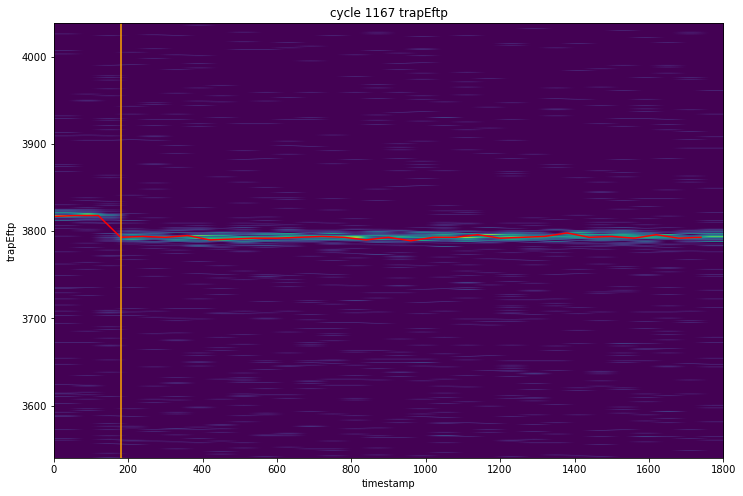

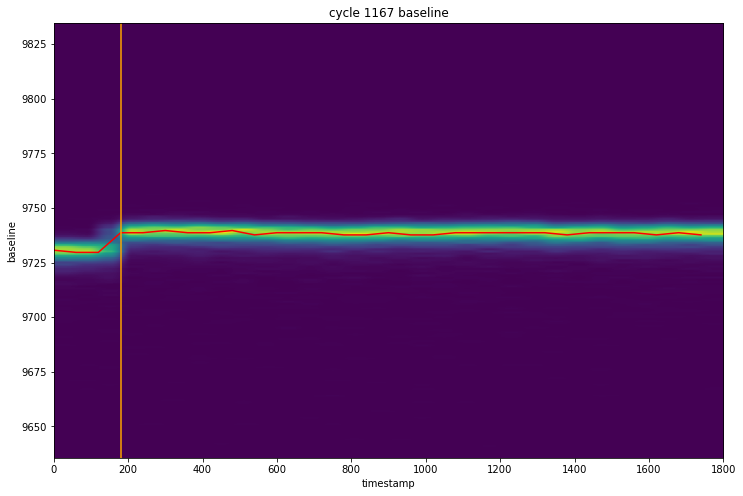

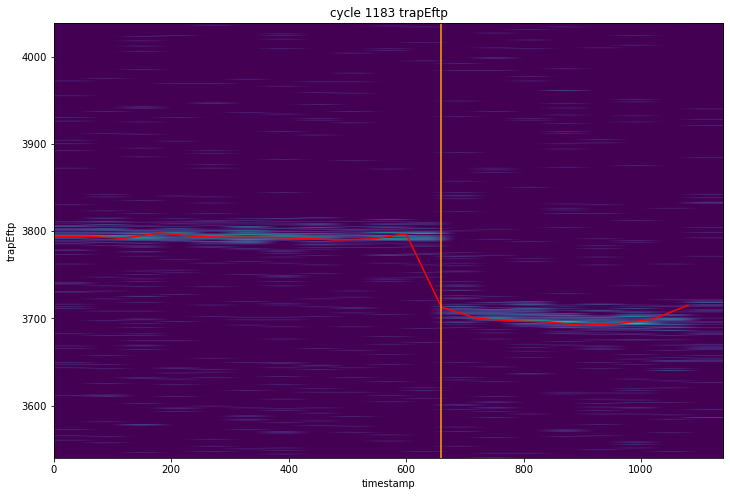

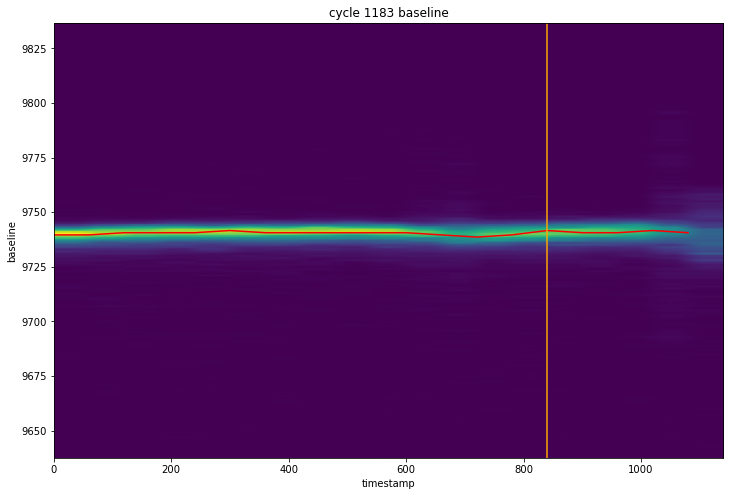

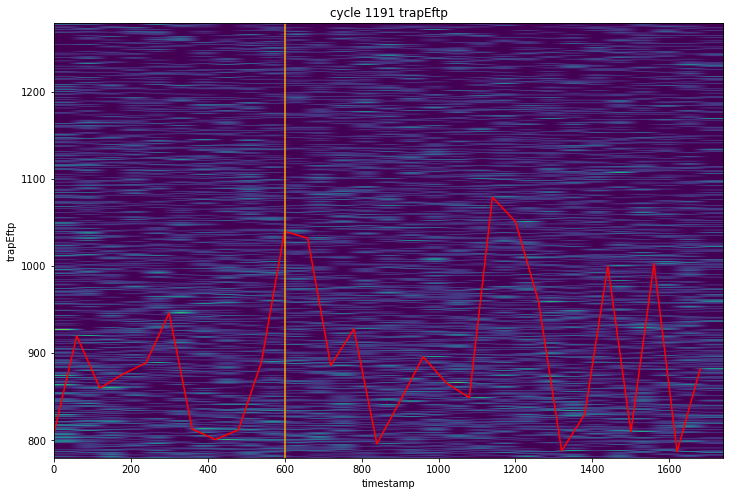

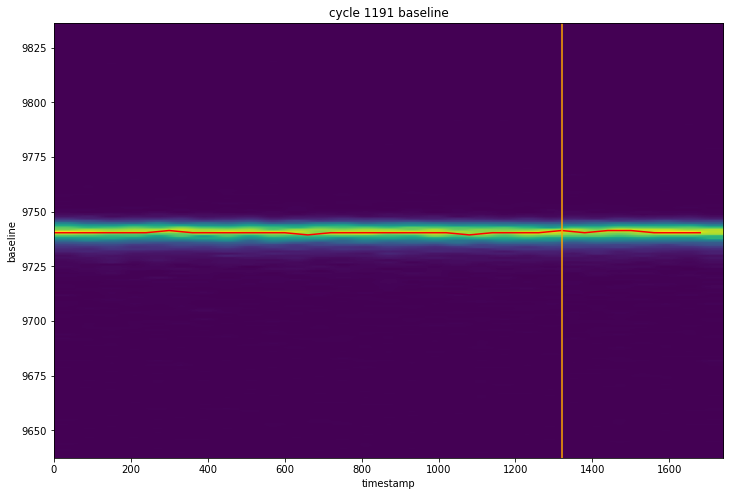

In [19]:
#runs=np.arange(77,78)
#find_jumps(runs,dsp_dir)
dg = DataGroup('../processing/cage.json', load=True)

#hist_jump_in_run(77, dg.fileDB.query(f'run == {77}')['cycle'], dsp_dir, plot=True)
jumps = find_jumps([107,109,111], dsp_dir)
print(jumps)

# Gain Stabilization Detection

In [ ]:
def hist_jump_in_run(dg, run, dsp_folder, plot=True):    
    df = dg.fileDB.query(f'run == {run}')
    cycles = df['cycle']

    f_dsp = f"{dsp_folder}/{df['dsp_file'].iloc[-1]}"
    dsp = h5py.File(f_dsp)

    ts_corrected = correct_timestamps(f_dsp)
    trapEftp = np.array(dsp['ORSIS3302DecoderForEnergy']['dsp']['trapEftp'])
    baseline = np.array(dsp['ORSIS3302DecoderForEnergy']['dsp']['bl'])

    adu1460 = find_1460(ts_corrected, trapEftp)
    bl = np.mean(baseline)


    energy_bins = np.arange(adu1460-250, adu1460+250)
    bl_bins = np.arange(bl-50, bl+51)
    time_bins = np.arange(0, df['startTime'].iloc[-1] - df['startTime'].iloc[0] + ts_corrected[-1], time_intervals)
    time_bins = np.append(time_bins, df['startTime'].iloc[-1] - df['startTime'].iloc[0] + ts_corrected[-1])


    ehists = np.zeros((len(time_bins)-1, len(energy_bins)-1))
    blhists = np.zeros((len(time_bins)-1, len(bl_bins)-1))


    for i in range(len(df)):
        f_dsp = f"{dsp_folder}/{df['dsp_file'].iloc[i]}"
        try:
            dsp = h5py.File(f_dsp)
        except OSError:
            continue
        trapEftp = np.array(dsp['ORSIS3302DecoderForEnergy']['dsp']['trapEftp'])
        baseline = np.array(dsp['ORSIS3302DecoderForEnergy']['dsp']['bl'])


        ts_corrected = np.array(correct_timestamps(f_dsp) + df['startTime'].iloc[i] - df['startTime'].iloc[0])

        e_cyc = np.histogram2d(ts_corrected, trapEftp, bins=[time_bins, energy_bins])
        b_cyc = np.histogram2d(ts_corrected, baseline, bins=[time_bins, bl_bins])


        ehists += e_cyc[0]
        blhists += b_cyc[0]

    if plot:
        e_data = list(zip([(t, e) for t in time_bins[:-1] for e in energy_bins[:-1]]))
        e_data = [e[0] for e in e_data]
        b_data = list(zip([(t, b) for t in time_bins[:-1] for b in bl_bins[:-1]]))
        b_data = [b[0] for b in b_data]

        ex = [e[0] for e in e_data]
        ey = [e[1] for e in e_data]
        bx = [b[0] for b in b_data]
        by = [b[1] for b in b_data]

        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(24,10))
        fig.suptitle(f'Run {run}')

        ax1.hist2d(ex, ey, bins=[time_bins, energy_bins], weights=np.ravel(ehists))
        ax1.set(xlabel='Timestamp (s)', ylabel='trapEftp (adu)')

        ax2.hist2d(bx, by, bins=[time_bins, bl_bins], weights=np.ravel(blhists))
        ax2.set(xlabel='Timestamp (s)', ylabel='Baseline (adu)')
    return ehists, blhists, time_bins, energy_bins, bl_bins

def fit_peaks(ehists, blhists, time_bins, energy_bins, bl_bins, plot=False):
    e_total = []
    b_total = []
    for j in range(len(time_bins)-1):
        e_max = np.amax(ehists[j][:])
        e_max_ind = np.argmax(ehists[j][:])
        e_hw = 0
        
        if e_max < 5:
            e_total.append((0,0))
            b_total.append((0,0))
            continue
        
        while ehists[j][e_max_ind + e_hw] > e_max/5 or ehists[j][e_max_ind - e_hw] > e_max/5:
            e_hw += 1
        #print(e_fwhm)
        if(e_hw < 10):
            n_bins_e = 2*e_hw
        else:
            n_bins_e = 4*e_hw

        
        try:
            e_pars, e_cov = gauss_mode_width_max(ehists[j][:], energy_bins, var=ehists[j], n_bins=n_bins_e+1, poissonLL=(e_max < 30) )
            e_total.append((e_pars[0], e_cov[0][0]))
        except KeyboardInterrupt:
            raise KeyboardInterrupt
        except:
            e_total.append((0,0))
            e_pars = [0,0,0]
        
        b_max = np.amax(blhists[j][:])
        b_max_ind = np.argmax(blhists[j][:])
        b_hw = 0
        while blhists[j][b_max_ind + b_hw] > b_max/5 or blhists[j][b_max_ind - b_hw] > b_max/5:
            b_hw += 1
        if(b_hw < 10):
            n_bins_b = 2*b_hw
        else:
            n_bins_b = 4*b_hw
        #print(np.abs(b_max_ind-b_fwhm))
        try:
            b_pars, b_cov = gauss_mode_width_max(blhists[j][:], bl_bins, var=blhists[j], n_bins=n_bins_b+1, poissonLL=(b_max < 25))
            b_total.append((b_pars[0], b_cov[0][0]))
        except KeyboardInterrupt:
            raise KeyboardInterrupt
        except:
            b_total.append((0,0))
            b_pars = [0,0,0]
           

        if plot:
            fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(24,10))
            fig.suptitle(f'Time {time_bins[j]}-{time_bins[j+1]}')

            ax1.hist(energy_bins[:-1], bins=energy_bins, weights=ehists[j])
            ax1.plot(energy_bins[:-1], e_pars[2] * np.exp(-(energy_bins[:-1] - e_pars[0])**2 / (2. * e_pars[1]**2)) )
            ax1.set(xlabel='trapEftp (adu)', ylabel='count')
            ax1.text(0.5, 0.5, f'nbins={n_bins_e+1}', horizontalalignment='center',verticalalignment='center', transform=ax1.transAxes)


            ax2.hist(bl_bins[:-1], bins=bl_bins, weights=blhists[j])
            ax2.plot(bl_bins[:-1], b_pars[2] * np.exp(-(bl_bins[:-1] - b_pars[0])**2 / (2. * b_pars[1]**2)) )
            ax2.set(xlabel='baseline (adu)', ylabel='count')            
            ax2.text(0.5, 0.5, f'nbins={n_bins_b+1}', horizontalalignment='center',verticalalignment='center', transform=ax2.transAxes)

            
        
    return e_total, b_total

# Returns: slope of up to first hour of data in run
def find_slope_in_run(time_bins, e_total, b_total):
    x = time_bins[-1]
    if x > 1800: 
        x = 1800
    x /= time_intervals
    try:
        e_fit = np.polyfit(time_bins[:int(x)], [e_total[j][0] for j in range(int(x))], 1, w=1/np.sqrt([e_total[j][1] for j in range(int(x))]), cov=True)
        b_fit = np.polyfit(time_bins[:int(x)], [b_total[j][0] for j in range(int(x))], 1, w=1/np.sqrt([b_total[j][1] for j in range(int(x))]), cov=True)
        return e_fit, b_fit
    except:
        return None

In [ ]:
dg = DataGroup('../processing/cage.json', load=True)

ehists, blhists, time_bins, energy_bins, bl_bins = hist_jump_in_run(dg, 138, dsp_dir, True)

In [ ]:
ehists, blhists, time_bins, energy_bins, bl_bins = hist_jump_in_run(dg, 141, dsp_dir, True)

In [ ]:
#a drift is a list [run, e_fit, b_fit]
def find_drifts(dg, runs, dsp_folder, plot=False, plot_fit=False):
    drifts = []
    if isinstance(runs, int):
        runs = [runs]
    
    for i in range(len(runs)):
        r = runs[i]
        df = dg.fileDB.query(f'run == {r}')
        ehists, blhists, time_bins, energy_bins, bl_bins = hist_jump_in_run(dg, r, dsp_folder, False)
        e_total, b_total = fit_peaks(ehists, blhists, time_bins, energy_bins, bl_bins, plot_fit)
        
        fit = find_slope_in_run(time_bins, e_total, b_total)
        if fit is not None:
            efit = fit[0]
            bfit = fit[1]
            efit_slope = efit[0][0]
            efit_int = efit[0][1]
            efit_unc = efit[1][0][0]
            bfit_slope = bfit[0][0]
            bfit_int = bfit[0][1]
            bfit_unc = bfit[1][0][0]
            print(r, efit_slope/efit_unc, bfit_slope/bfit_unc)
            if np.abs(efit_slope) > 10*efit_unc or np.abs(bfit_slope) > 10*bfit_unc:
                drifts.append((r,(efit_slope, efit[0][1], efit_unc), (bfit_slope, bfit[0][1], bfit_unc)))
        
            if plot:
                x = time_bins[-1]
                if x > 1800: 
                    x = 1800
                x /= time_intervals

                fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(24,10))
                fig.suptitle(f'Run {r}')

                ax1.errorbar(time_bins[:-1], [e[0] for e in e_total], np.zeros(len(time_bins)-1), [e[1] for e in e_total] )
                ax1.plot(time_bins[:int(x)], efit_slope*time_bins[:int(x)] + efit_int, label='slope = {:.2E} +- {:.2E}'.format(efit_slope, efit_unc), color='orange', linewidth=4)
                ax1.set(xlabel='timestamps', ylabel='trapEftp (adc)', ylim=(np.max(e_total[:][0])-50, (np.max(e_total[:][0])+50)))
                ax1.legend()

                ax2.plot(time_bins[:-1],  [b[0] for b in b_total], np.zeros(len(time_bins)-1), [b[1] for b in b_total])
                ax2.plot(time_bins[:int(x)], bfit_slope*time_bins[:int(x)] + bfit_int, label='slope = {:.2E} +- {:.2E}'.format(bfit_slope, bfit_unc), color='orange', linewidth=4)
                ax2.set(xlabel='timestamps', ylabel='baseline (adc)', ylim=(np.max(b_total[:][0])-30, (np.max(b_total[:][0])+30)))
                ax2.legend()
        elif plot:
            x = time_bins[-1]
            if x > 1800: 
                x = 1800
            x /= time_intervals

            fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(24,10))
            fig.suptitle(f'Run {r}')

            ax1.errorbar(time_bins[:-1], [e[0] for e in e_total], np.zeros(len(time_bins)-1), [e[1] for e in e_total] )
            ax1.set(xlabel='timestamps', ylabel='trapEftp (adc)', ylim=(np.max(e_total[:][0])-50, (np.max(e_total[:][0])+50)))
            ax1.legend()

            ax2.errorbar(time_bins[:-1],  [b[0] for b in b_total], np.zeros(len(time_bins)-1), [b[1] for b in b_total])
            ax2.set(xlabel='timestamps', ylabel='baseline (adc)', ylim=(np.max(b_total[:][0])-30, (np.max(b_total[:][0])+30)))
            ax2.legend()
                
    return drifts



In [ ]:
dg = DataGroup('../processing/cage.json', load=True)

df = dg.fileDB.query(f'run == {138}')
print(df.keys())
print(df['startTime'].iloc[0])
print(df['stopTime'].iloc[-1])
print(df['runtime'].iloc[0])

In [ ]:
d = find_drifts(dg, 141, dsp_dir, True, True)
print(*d, sep = "\n")

In [ ]:
d = find_drifts(dg, np.arange(136,172), dsp_dir, True, False)
print(*d, sep = "\n")

In [ ]:

runs=np.arange(60, 73)
d = find_drifts(runs,dsp_dir)

plot_drifts(d,dsp_dir)

In [ ]:
runs=np.arange(107, 234)
d = find_drifts(runs,dsp_dir)

plot_drifts(d,dsp_dir)

In [ ]:
dg = DataGroup('../processing/cage.json', load=True)
df = dg.fileDB.query(f'run == {77}')
print(df.keys())
print(df['stopTime'].iloc[-1] - df['startTime'].iloc[0])
print(df['stopTime'].iloc[-1] - df['startTime'].iloc[0])

In [ ]:
dg = DataGroup('../processing/cage.json', load=True)
df = dg.fileDB.query(f'run == {77}')
ehists, bhists = hist_jump_in_run(77, df['cycle'][:], dsp_dir, False)
t = 0
e_total = []
b_total = []
for i in np.arange(len(ehists)):
    ehist, t_edges, e_edges = ehists[i]
    bhist, t_edges, b_edges = bhists[i]
    ye = [e_edges[np.argmax(ehist[j][:])] for j in range(0, len(t_edges)-1)]
    yb = [b_edges[np.argmax(bhist[j][:])] for j in range(0, len(t_edges)-1)]
    e_total += ye
    b_total += yb
    t += len(t_edges - 1)
t_total = np.arange(0, len(e_total)*time_intervals, time_intervals)
print(t_total[-1])
x = len(t_total)
if x > 3600/time_intervals: 
    x = 3600/time_intervals
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(24,10))
fig.suptitle(f'Run 77')

ax1.plot(t_total, e_total)
ax1.set(xlabel='timestamps', ylabel='trapEftp (adc)', ylim=(np.mean(e_total)-20, np.mean(e_total)+20))
ax1.axvline(40000, color='r')

ax2.plot(t_total, b_total)
ax2.set(xlabel='timestamps', ylabel='baseline (adc)', ylim=(np.mean(b_total)-10, np.mean(b_total)+10))
ax2.axvline(50000, color='r')

In [ ]:
f_dsp = f"{dsp_dir}/cage_run108_cyc1179_dsp.lh5"
dsp = h5py.File(f_dsp)
trapEftp = np.array(dsp['ORSIS3302DecoderForEnergy']['dsp']['trapEftp'])
ts = np.array(dsp['ORSIS3302DecoderForEnergy']['dsp']['timestamp'])
ts_corrected = correct_timestamps(f_dsp)
plt.figure(figsize=(15,10))
eh = plt.hist2d(ts_corrected, trapEftp, bins=[np.arange(0, ts_corrected[-1],np.minimum(time_intervals, int(ts_corrected[-1]-1))),np.arange(0,6000)])[:-1]


In [ ]:
f_dsp = f"{dsp_dir}/cage_run111_cyc1191_dsp.lh5"
dsp = h5py.File(f_dsp)
trapEftp = np.array(dsp['ORSIS3302DecoderForEnergy']['dsp']['trapEftp'])
ts = np.array(dsp['ORSIS3302DecoderForEnergy']['dsp']['timestamp'])
ts_corrected = correct_timestamps(f_dsp)
plt.figure(figsize=(15,10))
eh = plt.hist2d(ts_corrected, trapEftp, bins=[np.arange(0, ts_corrected[-1],np.minimum(time_intervals, int(ts_corrected[-1]-1))),np.arange(0,6000)])[:-1]

# Peak Fitting

In [ ]:
from scipy.stats import norm

run = 107
cycles = np.arange(1164,1172)
ehists, blhists, _, _ = hist_jump_in_run(run, cycles, dsp_dir, False)

edata = ehists[0][0]
t_edges = ehists[0][1]
e_edges = ehists[0][2]
res = []
for j in range(len(t_edges)-1):
    try:
        plt.figure(figsize=(12,8))
        plt.plot(e_edges[:-1], edata[j]/np.linalg.norm(edata[j]))
        par = gauss_mode_width_max(edata[j], e_edges, mode_guess=e_edges[np.argmax(edata[j])], n_bins=5)[0]
        plt.plot(e_edges[:-1], norm.pdf(e_edges[:-1], loc=par[0], scale=par[1]))
        res.append(par[1])
    except RuntimeError:
        print(j)
print(res)

In [ ]:
run = 107
cycles = np.arange(1164,1172)
ehists, blhists, _, _ = hist_jump_in_run(run, cycles, dsp_dir, True)